# Import & Setup

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../src"))

from ab_test_engine import ABTestEngine
engine = ABTestEngine()



# T1.a) Which variant has more DAU after 15 days?

In [2]:
dau_A = engine.simulate_dau("A")
dau_B = engine.simulate_dau("B")

In [3]:
results_dau_15 = pd.DataFrame({
    "Day": np.arange(1, 16),
    "DAU_A": dau_A[:15],
    "DAU_B": dau_B[:15]
})

results_dau_15.head()


,Day,DAU_A,DAU_B
0,1,10600.000000,9600.000000
1,2,18165.712128,16528.203230
2,3,23565.712128,21528.203230
3,4,28375.933340,26196.660654
4,5,32660.790397,30555.559598


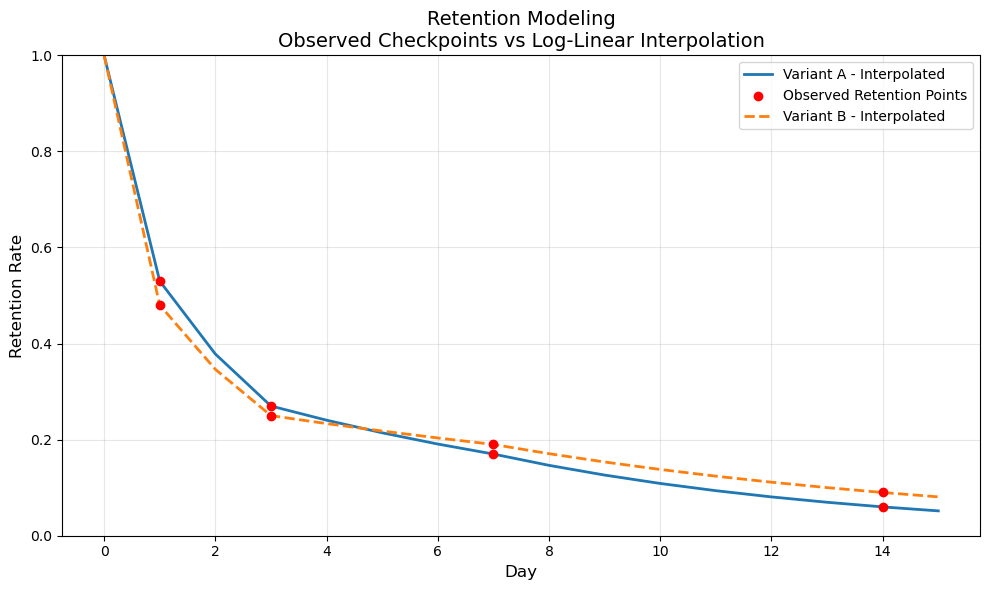

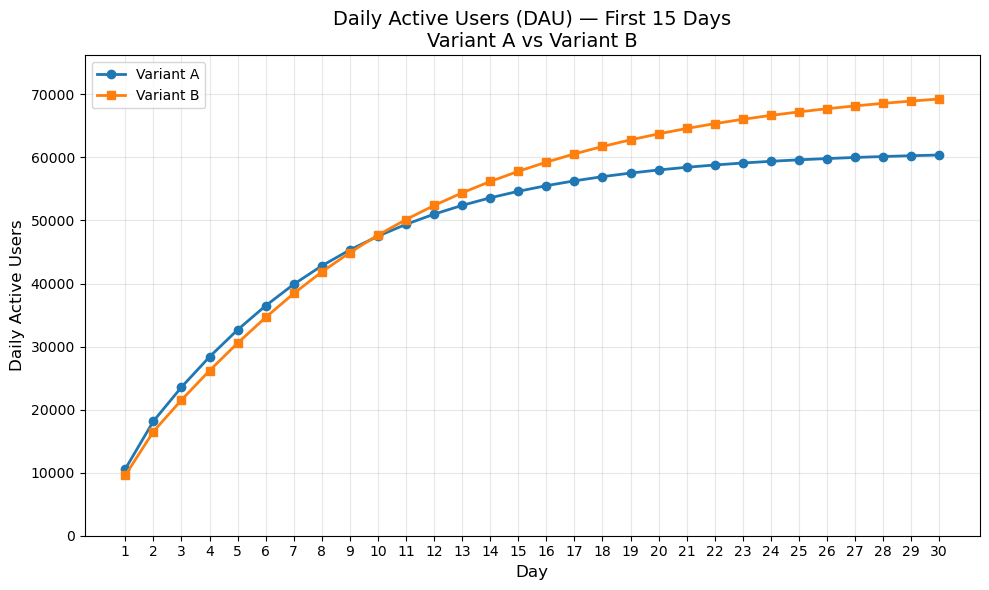

In [4]:
# Retention Curves (Observed vs Modeled)

plt.figure(figsize=(10, 6))

# Variant A
original_A = engine.variant_metrics["A"]["retention"]
curve_A = engine.interpolate_retention(original_A, 15)

plt.plot(
    list(curve_A.keys()),
    list(curve_A.values()),
    linewidth=2,
    label="Variant A - Interpolated"
)

plt.scatter(
    list(original_A.keys()),
    list(original_A.values()),
    color="red",
    zorder=5,
    label="Observed Retention Points"
)

# Variant B
original_B = engine.variant_metrics["B"]["retention"]
curve_B = engine.interpolate_retention(original_B, 15)

plt.plot(
    list(curve_B.keys()),
    list(curve_B.values()),
    linestyle="--",
    linewidth=2,
    label="Variant B - Interpolated"
)

plt.scatter(
    list(original_B.keys()),
    list(original_B.values()),
    color="red",
    zorder=5
)

plt.xlabel("Day", fontsize=12)
plt.ylabel("Retention Rate", fontsize=12)
plt.title("Retention Modeling\nObserved Checkpoints vs Log-Linear Interpolation", fontsize=14)

plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

results_dau_15 = pd.DataFrame({
    "Day": np.arange(1, 31),
    "DAU_A": dau_A[:30],
    "DAU_B": dau_B[:30]
})

plt.figure(figsize=(10, 6))

plt.plot(
    results_dau_15["Day"],
    results_dau_15["DAU_A"],
    marker="o",
    linewidth=2,
    label="Variant A"
)

plt.plot(
    results_dau_15["Day"],
    results_dau_15["DAU_B"],
    marker="s",
    linewidth=2,
    label="Variant B"
)

plt.xlabel("Day", fontsize=12)
plt.ylabel("Daily Active Users", fontsize=12)
plt.title("Daily Active Users (DAU) — First 15 Days\nVariant A vs Variant B", fontsize=14)

plt.ylim(0, max(results_dau_15[["DAU_A", "DAU_B"]].max()) * 1.1)
plt.xticks(results_dau_15["Day"])
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# T1.b) Which variant earns the most total money by Day 15?

In [5]:
# Run revenue simulation (base case)
(
    dau_A,
    daily_total_A,
    cumulative_A,
    daily_iap_A,
    daily_ad_A
) = engine.simulate_revenue("A")

(
    dau_B,
    daily_total_B,
    cumulative_B,
    daily_iap_B,
    daily_ad_B
) = engine.simulate_revenue("B")


# Focus on Day 15
rev_15_A = cumulative_A[14]
rev_15_B = cumulative_B[14]

print(f"Total Revenue by Day 15 - Variant A: {rev_15_A:,.2f}")
print(f"Total Revenue by Day 15 - Variant B: {rev_15_B:,.2f}")

winner = "A" if rev_15_A > rev_15_B else "B"
print(f"Winner: Variant {winner}")

# Extract cumulative components by Day 15
day_index = 14  # Day 15 (0-based index)

cum_ad_A = daily_ad_A[:15].sum()
cum_ad_B = daily_ad_B[:15].sum()

iap_volume_A = (dau_A[:15] * engine.variant_metrics["A"]["purchase_ratio"]).sum()
iap_volume_B = (dau_B[:15] * engine.variant_metrics["B"]["purchase_ratio"]).sum()

break_even_aov = (cum_ad_B - cum_ad_A) / (iap_volume_A - iap_volume_B)
print("Break-even Average Purchase Value (AOV):", break_even_aov)



Total Revenue by Day 15 - Variant A: 31,100.81
Total Revenue by Day 15 - Variant B: 28,427.05
Winner: Variant A
Break-even Average Purchase Value (AOV): 6.654947233840659


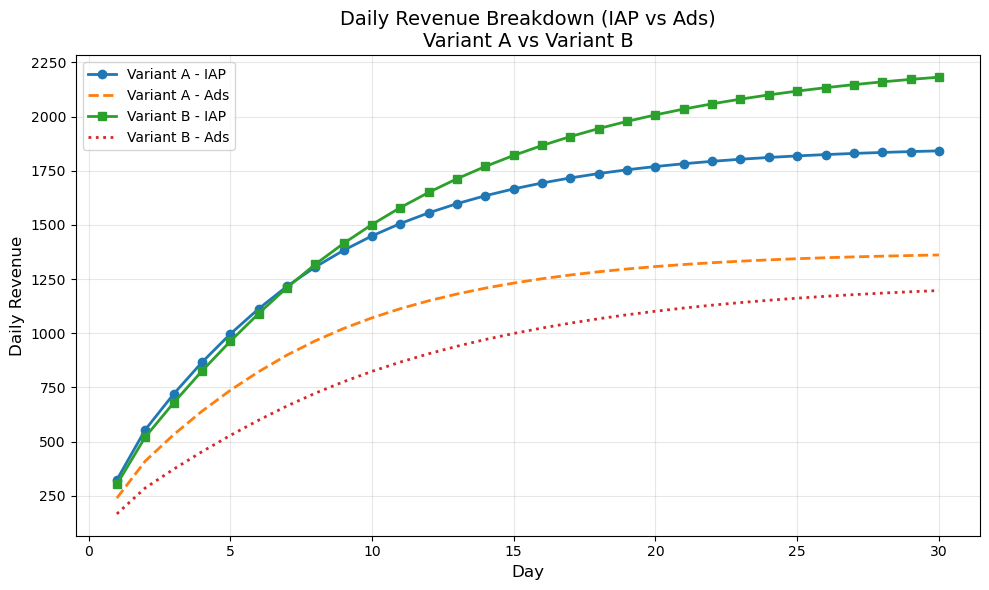

In [6]:
plt.figure(figsize=(10, 6))

# Variant A
plt.plot(
    np.arange(1, engine.simulation_days + 1),
    daily_iap_A,
    marker="o",
    linewidth=2,
    label="Variant A - IAP"
)

plt.plot(
    np.arange(1, engine.simulation_days + 1),
    daily_ad_A,
    linestyle="--",
    linewidth=2,
    label="Variant A - Ads"
)

# Variant B
plt.plot(
    np.arange(1, engine.simulation_days + 1),
    daily_iap_B,
    marker="s",
    linewidth=2,
    label="Variant B - IAP"
)

plt.plot(
    np.arange(1, engine.simulation_days + 1),
    daily_ad_B,
    linestyle=":",
    linewidth=2,
    label="Variant B - Ads"
)

plt.xlabel("Day", fontsize=12)
plt.ylabel("Daily Revenue", fontsize=12)
plt.title("Daily Revenue Breakdown (IAP vs Ads)\nVariant A vs Variant B", fontsize=14)

plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


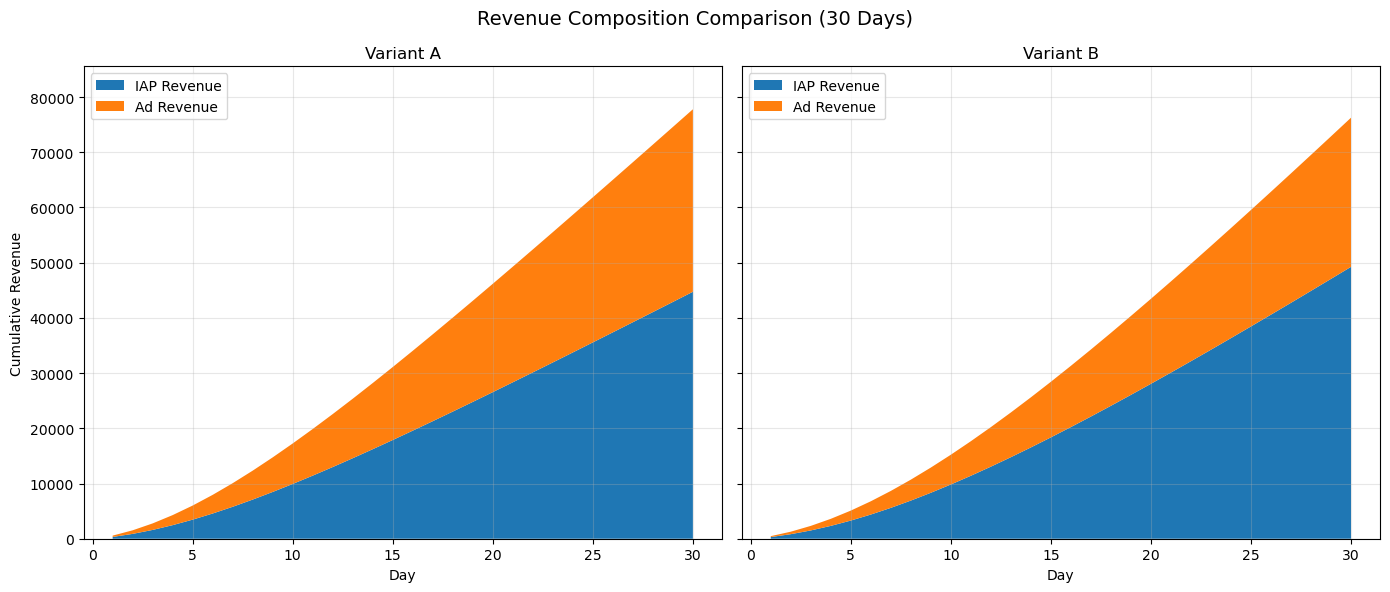

In [7]:
days = np.arange(1, engine.simulation_days + 1)

# Cumulative components
cum_iap_A = np.cumsum(daily_iap_A)
cum_ad_A = np.cumsum(daily_ad_A)
cum_total_A = cum_iap_A + cum_ad_A

cum_iap_B = np.cumsum(daily_iap_B)
cum_ad_B = np.cumsum(daily_ad_B)
cum_total_B = cum_iap_B + cum_ad_B

# Common Y-axis limit
y_max = max(cum_total_A.max(), cum_total_B.max()) * 1.1

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# -------------------------
# Variant A
# -------------------------
axes[0].stackplot(
    days,
    cum_iap_A,
    cum_ad_A,
    labels=["IAP Revenue", "Ad Revenue"]
)

axes[0].set_title("Variant A")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("Cumulative Revenue")
axes[0].set_ylim(0, y_max)
axes[0].grid(alpha=0.3)
axes[0].legend()

# -------------------------
# Variant B
# -------------------------
axes[1].stackplot(
    days,
    cum_iap_B,
    cum_ad_B,
    labels=["IAP Revenue", "Ad Revenue"]
)

axes[1].set_title("Variant B")
axes[1].set_xlabel("Day")
axes[1].set_ylim(0, y_max)
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.suptitle("Revenue Composition Comparison (30 Days)", fontsize=14)
plt.tight_layout()
plt.show()


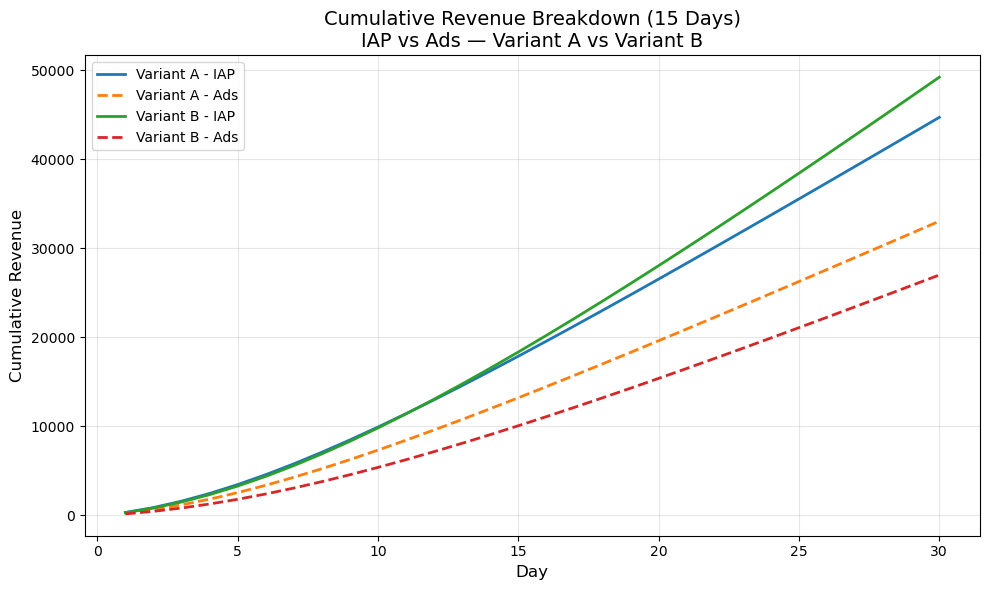

In [11]:
days = np.arange(1, 31)

# Compute cumulative components
cum_iap_A = np.cumsum(daily_iap_A)
cum_ad_A = np.cumsum(daily_ad_A)

cum_iap_B = np.cumsum(daily_iap_B)
cum_ad_B = np.cumsum(daily_ad_B)

plt.figure(figsize=(10, 6))

# Variant A
plt.plot(days, cum_iap_A, linewidth=2, label="Variant A - IAP")
plt.plot(days, cum_ad_A, linestyle="--", linewidth=2, label="Variant A - Ads")

# Variant B
plt.plot(days, cum_iap_B, linewidth=2, label="Variant B - IAP")
plt.plot(days, cum_ad_B, linestyle="--", linewidth=2, label="Variant B - Ads")

plt.xlabel("Day", fontsize=12)
plt.ylabel("Cumulative Revenue", fontsize=12)
plt.title("Cumulative Revenue Breakdown (15 Days)\nIAP vs Ads — Variant A vs Variant B", fontsize=14)

plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# T.1(c) If we look at the total money earned by Day 30 instead, does our choice change?

Total Revenue by Day 30 - Variant A: 77,787.43
Total Revenue by Day 30 - Variant B: 76,260.61
Winner by Day 30: Variant A


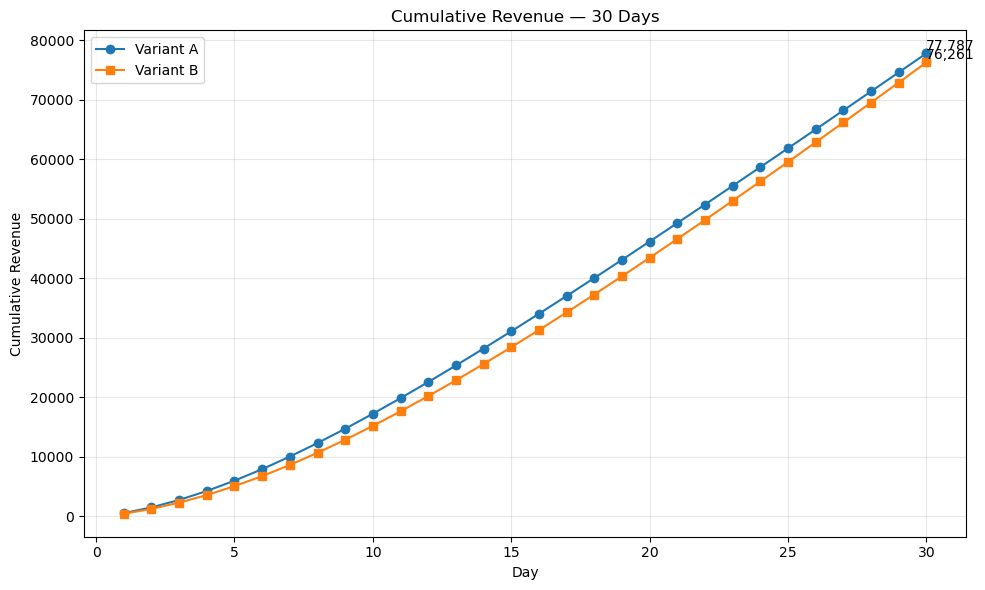

In [9]:
# Day 30 cumulative revenue
rev_30_A = cumulative_A[29]
rev_30_B = cumulative_B[29]

print(f"Total Revenue by Day 30 - Variant A: {rev_30_A:,.2f}")
print(f"Total Revenue by Day 30 - Variant B: {rev_30_B:,.2f}")

winner_c = "A" if rev_30_A > rev_30_B else "B"
print(f"Winner by Day 30: Variant {winner_c}")

plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, 31), cumulative_A, marker="o", label="Variant A")
plt.plot(np.arange(1, 31), cumulative_B, marker="s", label="Variant B")

plt.scatter(30, rev_30_A)
plt.scatter(30, rev_30_B)

plt.text(30, rev_30_A, f"{rev_30_A:,.0f}", va="bottom")
plt.text(30, rev_30_B, f"{rev_30_B:,.0f}", va="bottom")

plt.xlabel("Day")
plt.ylabel("Cumulative Revenue")
plt.title("Cumulative Revenue — 30 Days")

plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# T.1(d) What if we run a 10-day sale starting on Day 15 (boosting everyone's purchase rate by 1%)? Does this change which variant earns more total money by Day 30?


In [10]:
(
    dau_A_sale,
    daily_total_A_sale,
    cumulative_A_sale,
    daily_iap_A_sale,
    daily_ad_A_sale
) = engine.simulate_revenue("A", include_sale=True)

(
    dau_B_sale,
    daily_total_B_sale,
    cumulative_B_sale,
    daily_iap_B_sale,
    daily_ad_B_sale
) = engine.simulate_revenue("B", include_sale=True)


In [11]:
rev_30_A_sale = cumulative_A_sale[29]
rev_30_B_sale = cumulative_B_sale[29]

print(f"Total Revenue by Day 30 (Sale) - Variant A: {rev_30_A_sale:,.2f}")
print(f"Total Revenue by Day 30 (Sale) - Variant B: {rev_30_B_sale:,.2f}")

winner_d = "A" if rev_30_A_sale > rev_30_B_sale else "B"
print(f"Winner with Sale: Variant {winner_d}")


Total Revenue by Day 30 (Sale) - Variant A: 83,533.69
Total Revenue by Day 30 (Sale) - Variant B: 82,545.77
Winner with Sale: Variant A


In [12]:
print(f"Incremental Revenue from Sale - A: {rev_30_A_sale - cumulative_A[29]:,.2f}")
print(f"Incremental Revenue from Sale - B: {rev_30_B_sale - cumulative_B[29]:,.2f}")

Incremental Revenue from Sale - A: 5,746.26
Incremental Revenue from Sale - B: 6,285.16


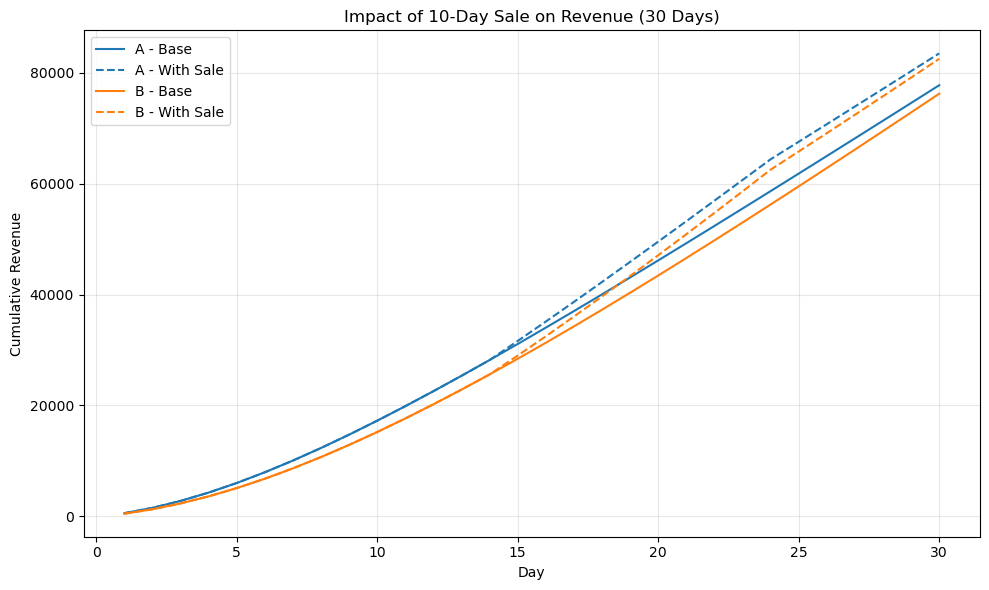

In [13]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, 31), cumulative_A, label="A - Base", color="C0")
plt.plot(np.arange(1, 31), cumulative_A_sale, linestyle="--", label="A - With Sale", color="C0")

plt.plot(np.arange(1, 31), cumulative_B, label="B - Base", color="C1")
plt.plot(np.arange(1, 31), cumulative_B_sale, linestyle="--", label="B - With Sale", color="C1")

plt.xlabel("Day")
plt.ylabel("Cumulative Revenue")
plt.title("Impact of 10-Day Sale on Revenue (30 Days)")

plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# T.1(e) On Day 20 we add a new user source.
From then on:
12,000 installs from original source
8,000 installs from new source
New users have different retention curves
With this mix, which variant earns more total money by Day 30?

In [14]:
(
    dau_A_new,
    daily_total_A_new,
    cumulative_A_new,
    daily_iap_A_new,
    daily_ad_A_new
) = engine.simulate_revenue("A", include_new_source=True)

(
    dau_B_new,
    daily_total_B_new,
    cumulative_B_new,
    daily_iap_B_new,
    daily_ad_B_new
) = engine.simulate_revenue("B", include_new_source=True)


In [15]:
rev_30_A_new = cumulative_A_new[29]
rev_30_B_new = cumulative_B_new[29]

print(f"Total Revenue by Day 30 (New Source) - Variant A: {rev_30_A_new:,.2f}")
print(f"Total Revenue by Day 30 (New Source) - Variant B: {rev_30_B_new:,.2f}")

winner_e = "A" if rev_30_A_new > rev_30_B_new else "B"
print(f"Winner with New Source: Variant {winner_e}")

impact_A_new = rev_30_A_new - cumulative_A[29]
impact_B_new = rev_30_B_new - cumulative_B[29]

print(f"Incremental Revenue from New Source - A: {impact_A_new:,.2f}")
print(f"Incremental Revenue from New Source - B: {impact_B_new:,.2f}")


Total Revenue by Day 30 (New Source) - Variant A: 81,266.82
Total Revenue by Day 30 (New Source) - Variant B: 79,126.72
Winner with New Source: Variant A
Incremental Revenue from New Source - A: 3,479.38
Incremental Revenue from New Source - B: 2,866.11


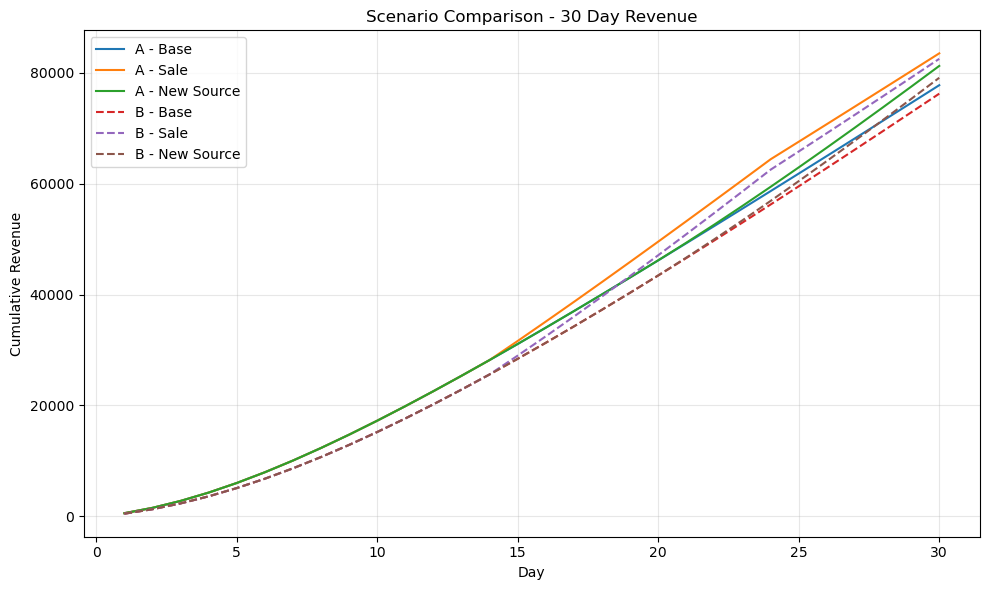

In [16]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, 31), cumulative_A, label="A - Base")
plt.plot(np.arange(1, 31), cumulative_A_sale, label="A - Sale")
plt.plot(np.arange(1, 31), cumulative_A_new, label="A - New Source")

plt.plot(np.arange(1, 31), cumulative_B, linestyle="--", label="B - Base")
plt.plot(np.arange(1, 31), cumulative_B_sale, linestyle="--", label="B - Sale")
plt.plot(np.arange(1, 31), cumulative_B_new, linestyle="--", label="B - New Source")

plt.xlabel("Day")
plt.ylabel("Cumulative Revenue")
plt.title("Scenario Comparison - 30 Day Revenue")

plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()